# Simulation analysis - Fair distribution of rewards
## Saturn Aliens

### Maria Silva, August 2022

In [1]:
import numpy as np
import pandas as pd
import scipy.special as sps  
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Generate service metrics

In [2]:
sample = 1000
np.random.seed(42)

#### Bandwidth - Gama distribution

mean:  1.0219951575351602
median:  0.811912528992922
std:  0.8119120166831512


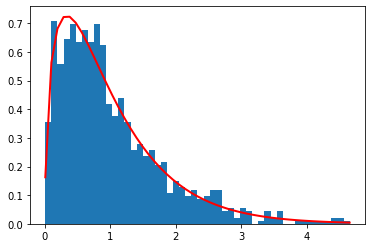

In [3]:
shape, scale = 1.5, 1/1.5
bandwidth_vec = np.random.gamma(shape, scale, sample)
print("mean: ", np.mean(bandwidth_vec))
print("median: ", np.median(bandwidth_vec))
print("std: ", np.std(bandwidth_vec))

count, bins, ignored = plt.hist(bandwidth_vec, 50, density=True)
y = bins**(shape-1)*(np.exp(-bins/scale)/(sps.gamma(shape)*scale**shape))
plt.plot(bins, y, linewidth=2, color='r')
plt.show()

#### TTFB threshold ratio - non-standard distribution

mean:  0.93
median:  1.0
std:  0.15524174696260024


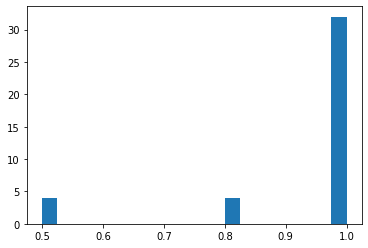

In [4]:
ttfb_vec = np.concatenate([0.5 * np.ones(int(0.1*sample)), 0.8 * np.ones(int(0.1*sample)), 1.0 * np.ones(int(0.8*sample))])
np.random.shuffle(ttfb_vec)
print("mean: ", np.mean(ttfb_vec))
print("median: ", np.median(ttfb_vec))
print("std: ", np.std(ttfb_vec))

plt.hist(ttfb_vec, 20, density=True)
plt.show()

#### Uptime - non-standard distribution

mean:  0.985
median:  1.0
std:  0.032015621187164243


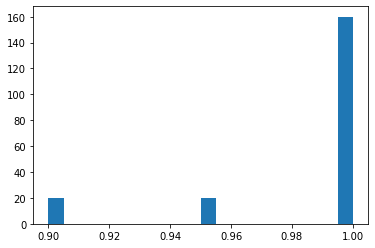

In [5]:
uptime_vec = np.concatenate([0.9 * np.ones(int(0.1*sample)), 0.95 * np.ones(int(0.1*sample)), 1.0 * np.ones(int(0.8*sample))])
np.random.shuffle(uptime_vec)
np.random.shuffle(uptime_vec)
print("mean: ", np.mean(uptime_vec))
print("median: ", np.median(uptime_vec))
print("std: ", np.std(uptime_vec))

plt.hist(uptime_vec, 20, density=True)
plt.show()

#### Combine data

In [6]:
metrics_df = pd.DataFrame(
    {
        "node_id": np.arange(sample),
        "bandwidth": bandwidth_vec,
        "ttfb_ratio": ttfb_vec,
        "uptime": uptime_vec
    }
)

metrics_df.head()

,node_id,bandwidth,ttfb_ratio,uptime
0,0,1.193082,1.0,1.0
1,1,0.682404,1.0,1.0
2,2,0.621059,0.5,1.0
3,3,0.621069,1.0,1.0
4,4,2.559175,0.8,0.9


## 2. Analyse payout distribution - single epoch w/ linear combination

We will test different service scoring functions:

1. Balanced linear - individual linear scoring functions + linear combination split equally between the three services 
2. Balanced sub-linear - individual sub-linear scoring functions + linear combination split equally between the three services 
3. Balanced supra-linear - individual supra-linear scoring functions + linear combination split equally between the three services
4. High bandwidth linear - individual linear scoring functions + linear combination with higher weight for bandwidth
5. High bandwidth sub-linear - individual sub-linear scoring functions + linear combination with higher weight for bandwidth
6. High bandwidth supra-linear - individual supra-linear scoring functions + linear combination with higher weight for bandwidth

Recall that the general scoring function used is defined as:

$S(m_i) := \frac{m_i^k}{\sum_{j=1}^n m_j^k}$

where $m_i$ is the service metric for node $i$ and $k \in \mathbb{R}^+$ is any real positive value.

In [7]:
def score_single(metric_vec, k):
    denom = sum(metric_vec**k)
    score_vec = metric_vec**k / denom
    return score_vec

def compute_gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

#### Compute payouts for $R = 1$

In [8]:
# copy df
score_df = metrics_df.copy(deep=True)

# Bandwidth scoring functions
score_df["bandwidth_sublinear"] = score_single(score_df["bandwidth"].values, 0.5)
score_df["bandwidth_linear"] = score_single(score_df["bandwidth"].values, 1.0)
score_df["bandwidth_supralinear"] = score_single(score_df["bandwidth"].values, 2.0)

# TTFB scoring functions
score_df["ttfb_sublinear"] = score_single(score_df["ttfb_ratio"].values, 0.5)
score_df["ttfb_linear"] = score_single(score_df["ttfb_ratio"].values, 1.0)
score_df["ttfb_supralinear"] = score_single(score_df["ttfb_ratio"].values, 2.0)

# Uptime scoring functions
score_df["uptime_sublinear"] = score_single(score_df["uptime"].values, 0.5)
score_df["uptime_linear"] = score_single(score_df["uptime"].values, 1.0)
score_df["uptime_supralinear"] = score_single(score_df["uptime"].values, 2.0)

In [9]:
# Combining individual scoring functions - balanced
score_df["balanced_sublinear"] = (
    (1.0/3.0) * score_df["bandwidth_sublinear"] +
    (1.0/3.0) * score_df["ttfb_sublinear"] +
    (1.0/3.0) * score_df["uptime_sublinear"]
) 
score_df["balanced_linear"] = (
    (1.0/3.0) * score_df["bandwidth_linear"] +
    (1.0/3.0) * score_df["ttfb_linear"] +
    (1.0/3.0) * score_df["uptime_linear"]
) 

score_df["balanced_supralinear"] = (
    (1.0/3.0) * score_df["bandwidth_linear"] +
    (1.0/3.0) * score_df["ttfb_supralinear"] +
    (1.0/3.0) * score_df["bandwidth_supralinear"]
)

In [10]:
# Combining individual scoring functions - high bandwidth
score_df["high_bw_sublinear"] = (
    0.5 * score_df["bandwidth_sublinear"] +
    0.25 * score_df["ttfb_sublinear"] +
    0.25 * score_df["uptime_sublinear"]
) 
score_df["high_bw_linear"] = (
    0.5 * score_df["bandwidth_linear"] +
    0.25 * score_df["ttfb_linear"] +
    0.25 * score_df["uptime_linear"]
) 
score_df["high_bw_supralinear"] = (
    0.5 * score_df["bandwidth_linear"] +
    0.25 * score_df["ttfb_supralinear"] +
    0.25 * score_df["bandwidth_supralinear"]
)

#### Explore payout distribution

Here are the Gini coefficient of each scoring function. Recall that the Gini coefficient varies between 0 and 1, with 0 expressing perfect equality and 1 expressing maximal inequality among values.

In [11]:
score_df.iloc[:, -6:].apply(lambda x: compute_gini(x.values), axis=0)

balanced_sublinear      0.079901
balanced_linear         0.143888
balanced_supralinear    0.369626
high_bw_sublinear       0.117397
high_bw_linear          0.210802
high_bw_supralinear     0.380111
dtype: float64

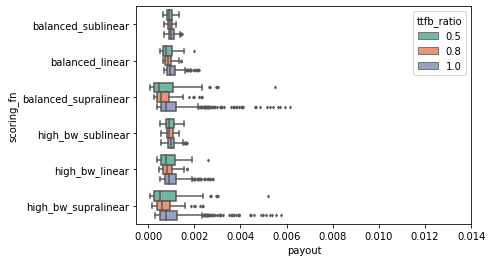

In [12]:
id_cols = list(score_df.iloc[:, :-6].columns)
melt_df = pd.melt(score_df, id_vars=id_cols, var_name='scoring_fn', value_name='payout')

sns.boxplot(y="scoring_fn", x="payout", hue="ttfb_ratio", data=melt_df, 
            palette="Set2", orient="h", fliersize=2)
plt.xlim(-0.0005, 0.014)
plt.show()

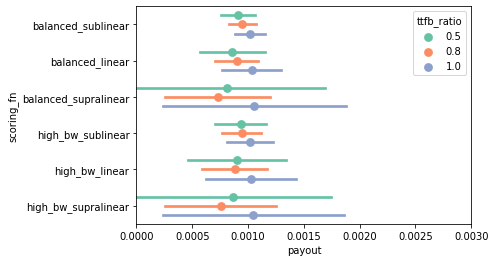

In [13]:
sns.pointplot(y="scoring_fn", x="payout", hue="ttfb_ratio", data=melt_df, ci="sd",
            dodge=0.5,join=False, palette="Set2", orient="h")
plt.xlim(0, 0.003)
plt.show()

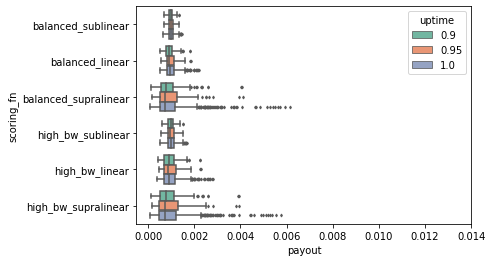

In [14]:
sns.boxplot(y="scoring_fn", x="payout", hue="uptime", data=melt_df, 
            palette="Set2", orient="h", fliersize=2)
plt.xlim(-0.0005, 0.014)
plt.show()

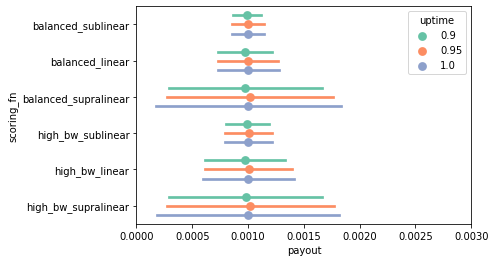

In [15]:
sns.pointplot(y="scoring_fn", x="payout", hue="uptime", data=melt_df, ci="sd",
            dodge=0.5,join=False, palette="Set2", orient="h")
plt.xlim(0, 0.003)
plt.show()

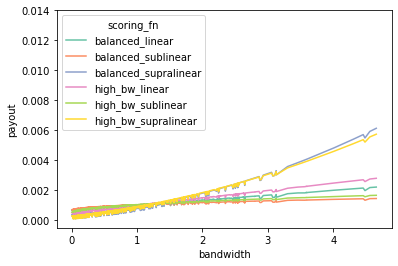

In [16]:
sns.lineplot(x="bandwidth", y="payout", hue="scoring_fn", palette="Set2",
             data=melt_df.sort_values(["scoring_fn", "bandwidth"]))
plt.ylim(-0.0005, 0.014)
plt.show()

## 3. Analyse payout distribution - single epoch w/ direct multiplication

Recall that direct multiplication the scoring function is as follows:

$S(a_i, b_i, c_i)= \frac{a_i^m \cdot b_i^n \cdot c_i^p}{\sum_{j=1}^n a_j^m \cdot b_j^n \cdot c_j^p}$

where $a_i$, $b_i$, $c_i$ are the three service metrics for node $i$ and $m,n,k \in \mathbb{R}^+$ are any real positive values.

We will test varying the $m$, $n$  and $k$ in order to test different scoring functions:

- All sublinear: $m = n = k = 0.5$
- All linear: $m = n = k = 1$
- All supralinear: $m = n = k = 2$
- Bandwidth smooth: $m = 1$ (linear bandwidth), $n = k = 0.5$ (sublinear ttfb and uptime)



#### Compute payouts for $R = 1$

In [17]:
# copy df
mscore_df = metrics_df.copy(deep=True)

# All sublinear
mscore_df["all_sublinear"] = (
    mscore_df["bandwidth"]**0.5 *
    mscore_df["ttfb_ratio"]**0.5 *
    mscore_df["uptime"]**0.5
) 
mscore_df["all_sublinear"] = mscore_df["all_sublinear"]/sum(mscore_df["all_sublinear"])

# All linear
mscore_df["all_linear"] = (
    mscore_df["bandwidth"] *
    mscore_df["ttfb_ratio"] *
    mscore_df["uptime"]
) 
mscore_df["all_linear"] = mscore_df["all_linear"]/sum(mscore_df["all_linear"])

# All supralinear
mscore_df["all_supralinear"] = (
    mscore_df["bandwidth"]**2 *
    mscore_df["ttfb_ratio"]**2 *
    mscore_df["uptime"]**2
) 
mscore_df["all_supralinear"] = mscore_df["all_supralinear"]/sum(mscore_df["all_supralinear"])

# More bandwidth
mscore_df["bandwidth_smooth"] = (
    mscore_df["bandwidth"] *
    mscore_df["ttfb_ratio"]**0.5 *
    mscore_df["uptime"]**0.5
) 
mscore_df["bandwidth_smooth"] = mscore_df["bandwidth_smooth"]/sum(mscore_df["bandwidth_smooth"])

mscore_df.head()

,node_id,bandwidth,ttfb_ratio,uptime,all_sublinear,all_linear,all_supralinear,bandwidth_smooth
0,0,1.193082,1.0,1.0,0.001226,0.001272,0.000962,0.001224
1,1,0.682404,1.0,1.0,0.000927,0.000728,0.000315,0.000700
2,2,0.621059,0.5,1.0,0.000625,0.000331,0.000065,0.000451
3,3,0.621069,1.0,1.0,0.000884,0.000662,0.000261,0.000637
4,4,2.559175,0.8,0.9,0.001523,0.001965,0.002295,0.002228


#### Explore payout distribution

Here are the Gini coefficient of each scoring function. Recall that the Gini coefficient varies between 0 and 1, with 0 expressing perfect equality and 1 expressing maximal inequality among values.

In [18]:
mscore_df.iloc[:, -4:].apply(lambda x: compute_gini(x.values), axis=0)

all_sublinear       0.239131
all_linear          0.427477
all_supralinear     0.684226
bandwidth_smooth    0.419714
dtype: float64

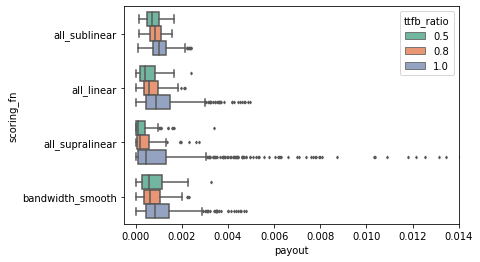

In [19]:
id_cols = list(mscore_df.iloc[:, :-4].columns)
m_melt_df = pd.melt(mscore_df, id_vars=id_cols, var_name='scoring_fn', value_name='payout')

sns.boxplot(y="scoring_fn", x="payout", hue="ttfb_ratio", data=m_melt_df, 
            palette="Set2", orient="h", fliersize=2)
plt.xlim(-0.0005, 0.014)
plt.show()

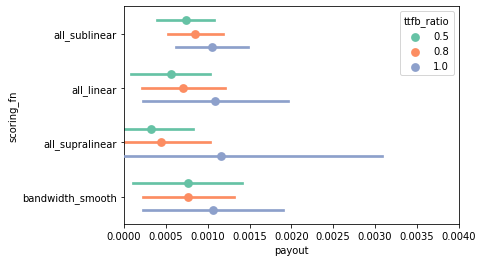

In [20]:
sns.pointplot(y="scoring_fn", x="payout", hue="ttfb_ratio", data=m_melt_df, ci="sd",
            dodge=0.5,join=False, palette="Set2", orient="h")
plt.xlim(0, 0.004)
plt.show()

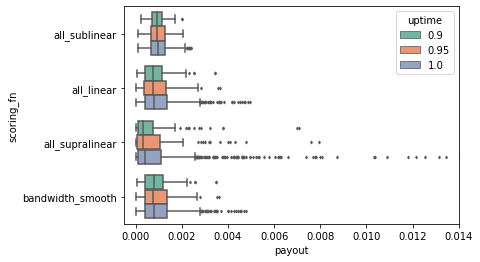

In [21]:
sns.boxplot(y="scoring_fn", x="payout", hue="uptime", data=m_melt_df, 
            palette="Set2", orient="h", fliersize=2)
plt.xlim(-0.0005, 0.014)
plt.show()

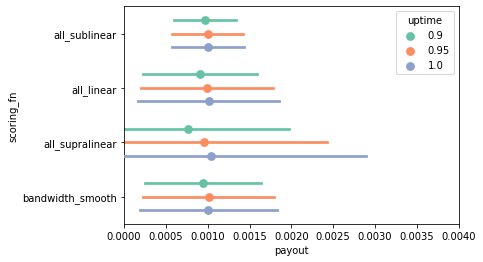

In [22]:
sns.pointplot(y="scoring_fn", x="payout", hue="uptime", data=m_melt_df, ci="sd",
            dodge=0.5,join=False, palette="Set2", orient="h")
plt.xlim(0, 0.004)
plt.show()

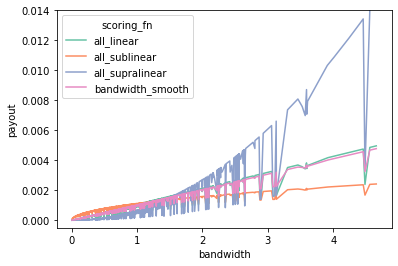

In [23]:
sns.lineplot(x="bandwidth", y="payout", hue="scoring_fn", palette="Set2",
             data=m_melt_df.sort_values(["scoring_fn", "bandwidth"]))
plt.ylim(-0.0005, 0.014)
plt.show()

## 4. Analyse payout distribution - multiple epochs w/ increasing R


In [24]:
n_epochs = 30
R = 1
R_increase = 0.01

#### Compute payouts for linear combination

In [25]:
score_month_df = score_df.copy(deep=True)
only_score_df = score_month_df.iloc[:,-6:]

for i in range(n_epochs):
    only_score_df += only_score_df*R*(1+R_increase)**i
    
score_month_df.iloc[:,-6:] = only_score_df

score_month_df.iloc[:, -6:].apply(lambda x: compute_gini(x.values), axis=0)

balanced_sublinear      0.079901
balanced_linear         0.143888
balanced_supralinear    0.369626
high_bw_sublinear       0.117397
high_bw_linear          0.210802
high_bw_supralinear     0.380111
dtype: float64

In [26]:
# min and max in million FIL
score_month_df.iloc[:, -6:].agg(["min", "max"])/(10**7)

,balanced_sublinear,balanced_linear,balanced_supralinear,high_bw_sublinear,high_bw_linear,high_bw_supralinear
min,0.666152,0.536457,0.107046,0.546109,0.417636,0.087394
max,1.509793,2.302418,6.376807,1.732323,2.910536,5.966328


#### Compute payouts for linear combination

In [27]:
mscore_month_df = mscore_df.copy(deep=True)
only_mscore_df = mscore_month_df.iloc[:,-4:]

for i in range(n_epochs):
    only_mscore_df += only_mscore_df*R*(1+R_increase)**i
    
mscore_month_df.iloc[:,-4:] = only_mscore_df

mscore_month_df.iloc[:, -4:].apply(lambda x: compute_gini(x.values), axis=0)

all_sublinear       0.239131
all_linear          0.427477
all_supralinear     0.684226
bandwidth_smooth    0.419714
dtype: float64

In [28]:
# min and max in million FIL
mscore_month_df.iloc[:, -4:].agg(["min", "max"])/(10**7)

,all_sublinear,all_linear,all_supralinear,bandwidth_smooth
min,0.089926,0.006587,0.000025,0.006504
max,2.516687,5.159182,15.234826,4.965118
